<a href="https://colab.research.google.com/github/aishuAK05/Potholes-Detection-Project-Using-Python-Image-Segmentation/blob/main/Pothole_Detection_Using_YOLOv8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
!pip install roboflow opencv-python numpy matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 43.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [ ]:
import cv2
import numpy as np
from roboflow import Roboflow
from google.colab import files
from google.colab.patches import cv2_imshow
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [ ]:
# Initialize Roboflow
rf = Roboflow(api_key="5R8HpzgJTrpTUTeP8r6p")
project = rf.workspace().project("real-time-road-anomalies-detection-in-different-weather-conditions-and-lightning-1582o")
model = project.version("2").model

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
class MetricsTracker:
    def __init__(self):
        self.predictions = []
        self.confidences = []
        self.class_counts = defaultdict(int)

    def add_prediction(self, prediction):
        self.predictions.append(prediction)
        self.confidences.append(prediction['confidence'])
        self.class_counts[prediction['class']] += 1

    def plot_confidence_distribution(self):
        plt.figure(figsize=(10, 6))
        sns.histplot(self.confidences, bins=20)
        plt.title('Distribution of Confidence Scores')
        plt.xlabel('Confidence Score')
        plt.ylabel('Count')
        plt.show()

    def calculate_metrics(self):
        # Note: These are simplified metrics based on predictions
        # For true metrics, you'd need ground truth data
        total_predictions = len(self.predictions)
        avg_confidence = np.mean(self.confidences) if self.confidences else 0

        return {
            'total_predictions': total_predictions,
            'average_confidence': avg_confidence,
            'class_distribution': dict(self.class_counts)
             }

def draw_labeled_box(image, prediction):
    """Draw a labeled bounding box with confidence score"""
    x, y, w, h = (prediction['x'], prediction['y'],
                  prediction['width'], prediction['height'])
    confidence = prediction['confidence']
    class_name = prediction['class']


    # Calculate coordinates
    x1 = int(x - w/2)
    y1 = int(y - h/2)
    x2 = int(x + w/2)
    y2 = int(y + h/2)

    # Draw box
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Prepare label text
    label = f"{class_name}: {confidence:.2f}"

    # Draw label background
    label_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    cv2.rectangle(image, (x1, y1 - label_size[1] - baseline),
                 (x1 + label_size[0], y1), (0, 255, 0), cv2.FILLED)

    # Draw label text
    cv2.putText(image, label, (x1, y1 - baseline),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    return image

def process_image(image_path, metrics_tracker):
    """Process image with metrics tracking"""
    # Read the image
    image = cv2.imread(image_path)

    # Predict on the image
    results = model.predict(image_path, confidence=40, overlap=30).json()

    # Draw labeled boxes and track metrics
    for prediction in results['predictions']:
        image = draw_labeled_box(image, prediction)
        metrics_tracker.add_prediction(prediction)

    return image, results['predictions']

def process_video(video_path, output_path, metrics_tracker):
    """Process video with metrics tracking"""
    cap = cv2.VideoCapture(video_path)

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Save the frame temporarily
        temp_frame_path = 'temp_frame.jpg'
        cv2.imwrite(temp_frame_path, frame)

        # Process the frame
        try:
            processed_frame, predictions = process_image(temp_frame_path, metrics_tracker)
            out.write(processed_frame)
        except Exception as e:
            print(f"Error processing frame {frame_count}: {str(e)}")
        finally:
            if os.path.exists(temp_frame_path):
                os.remove(temp_frame_path)


        frame_count += 1
        if frame_count % 30 == 0:  # Show progress every 30 frames
            print(f"Processed {frame_count} frames...")

    cap.release()
    out.release()
    print(f"Video processing complete. Processed {frame_count} frames.")


def handle_image_input(metrics_tracker):
    """Handle image input with metrics"""
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f"\nProcessing {filename}...")
        try:
            processed_image, predictions = process_image(filename, metrics_tracker)
            cv2_imshow(processed_image)
            output_filename = f"processed_{filename}"
            cv2.imwrite(output_filename, processed_image)
            files.download(output_filename)
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")

def handle_video_input(metrics_tracker):
    """Handle video input with metrics"""
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f"\nProcessing {filename}...")
        try:
            output_filename = f"processed_{filename}"
            process_video(filename, output_filename, metrics_tracker)
            files.download(output_filename)
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")

def display_metrics(metrics_tracker):
    """Display all metrics and visualizations"""
    print("\n=== Detection Metrics ===")
    metrics = metrics_tracker.calculate_metrics()
    print(f"Total Detections: {metrics['total_predictions']}")
    print(f"Average Confidence: {metrics['average_confidence']:.2f}")


    print("\nGenerating visualizations...")
    metrics_tracker.plot_confidence_distribution()



metrics_tracker = MetricsTracker()


Enter 'image' for image input, 'video' for video input, or 'quit' to exit: image


Saving 954dfe16-84c7-42a9-9722-a34d38740a2b.jpg to 954dfe16-84c7-42a9-9722-a34d38740a2b.jpg

Processing 954dfe16-84c7-42a9-9722-a34d38740a2b.jpg...


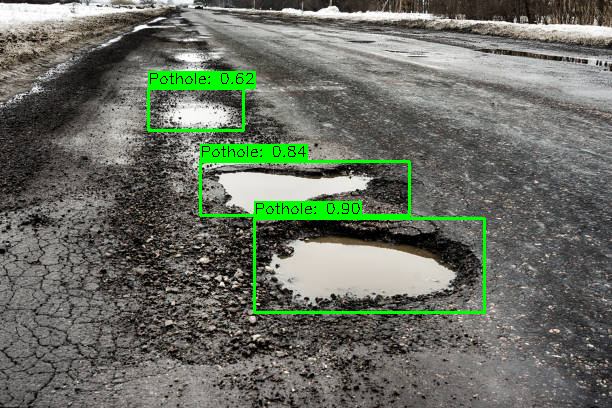

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Detection Metrics ===
Total Detections: 3
Average Confidence: 0.79

Generating visualizations...


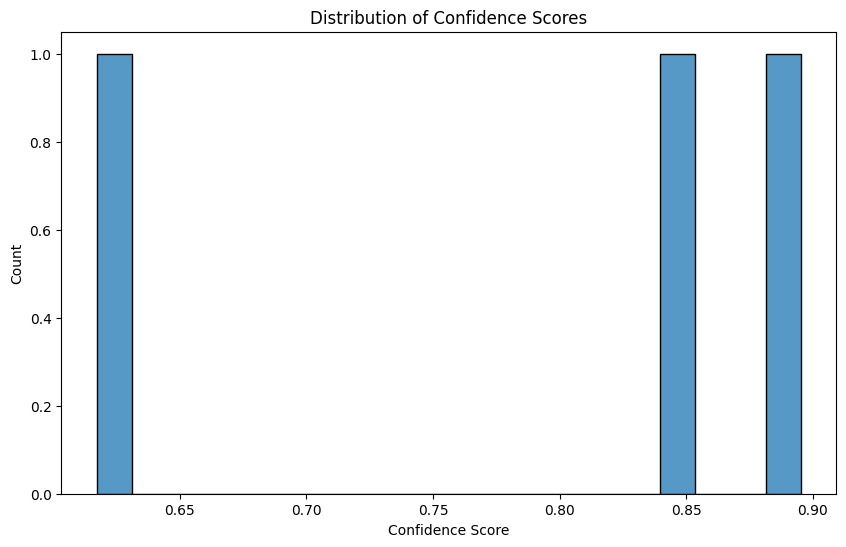

Do you want to process another input? (yes/no): yes

Enter 'image' for image input, 'video' for video input, or 'quit' to exit: video


Saving WhatsApp Video 2024-10-15 at 11.38.49 AM.mp4 to WhatsApp Video 2024-10-15 at 11.38.49 AM.mp4

Processing WhatsApp Video 2024-10-15 at 11.38.49 AM.mp4...
Processed 30 frames...
Processed 60 frames...
Processed 90 frames...
Processed 120 frames...
Processed 150 frames...
Processed 180 frames...
Processed 210 frames...
Processed 240 frames...
Processed 270 frames...
Processed 300 frames...
Processed 330 frames...
Processed 360 frames...
Processed 390 frames...
Processed 420 frames...
Processed 450 frames...
Processed 480 frames...
Processed 510 frames...
Processed 540 frames...
Processed 570 frames...
Processed 600 frames...
Processed 630 frames...
Processed 660 frames...
Processed 690 frames...
Video processing complete. Processed 692 frames.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Detection Metrics ===
Total Detections: 3023
Average Confidence: 0.70

Generating visualizations...


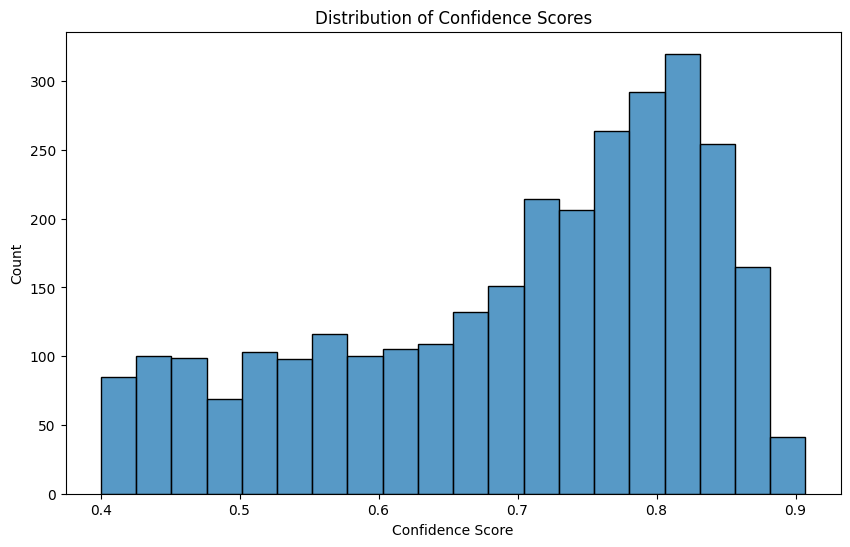

Do you want to process another input? (yes/no): no

Final Metrics and Visualizations:

=== Detection Metrics ===
Total Detections: 3023
Average Confidence: 0.70

Generating visualizations...


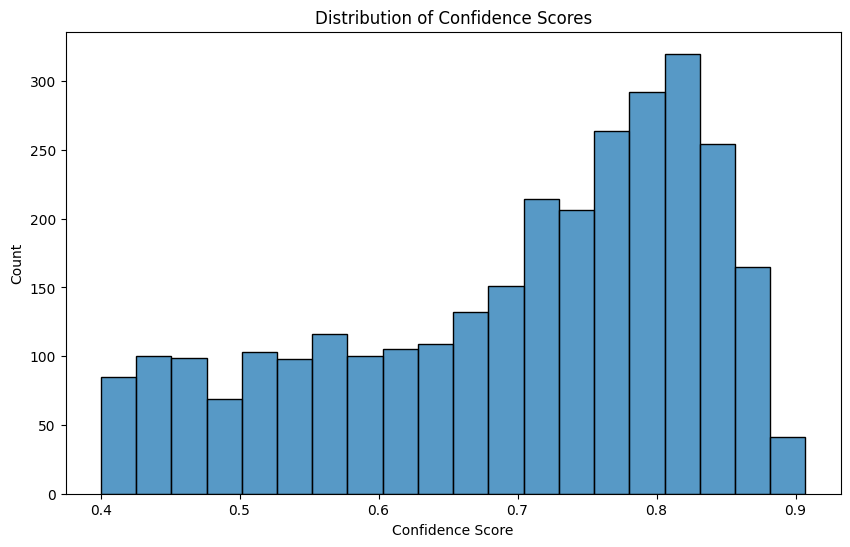


Thank you for using the pothole detection model!


In [ ]:
 def main():
  while True:
          input_type = input("\nEnter 'image' for image input, 'video' for video input, or 'quit' to exit: ")

          if input_type.lower() == 'quit':
              break
          elif input_type.lower() == 'image':
              handle_image_input(metrics_tracker)
          elif input_type.lower() == 'video':
              handle_video_input(metrics_tracker)
          else:
              print("Invalid input type. Please enter 'image', 'video', or 'quit'.")
              continue

          # Display metrics after each processing
          display_metrics(metrics_tracker)

          continue_processing = input("Do you want to process another input? (yes/no): ")
          if continue_processing.lower() != 'yes':
            break

  print("\nFinal Metrics and Visualizations:")
  display_metrics(metrics_tracker)
  print("\nThank you for using the pothole detection model!")

if __name__ == "__main__":
    main()